Using TensorFlow backend.
/home/rjpg/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:34: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rjpg/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 7, 5)       0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 20, 7, 5)      220         input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 20, 7, 5)      0           conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 20, 6, 5)      0           activation_1[0][0]               
___________________________________________________________________________________________

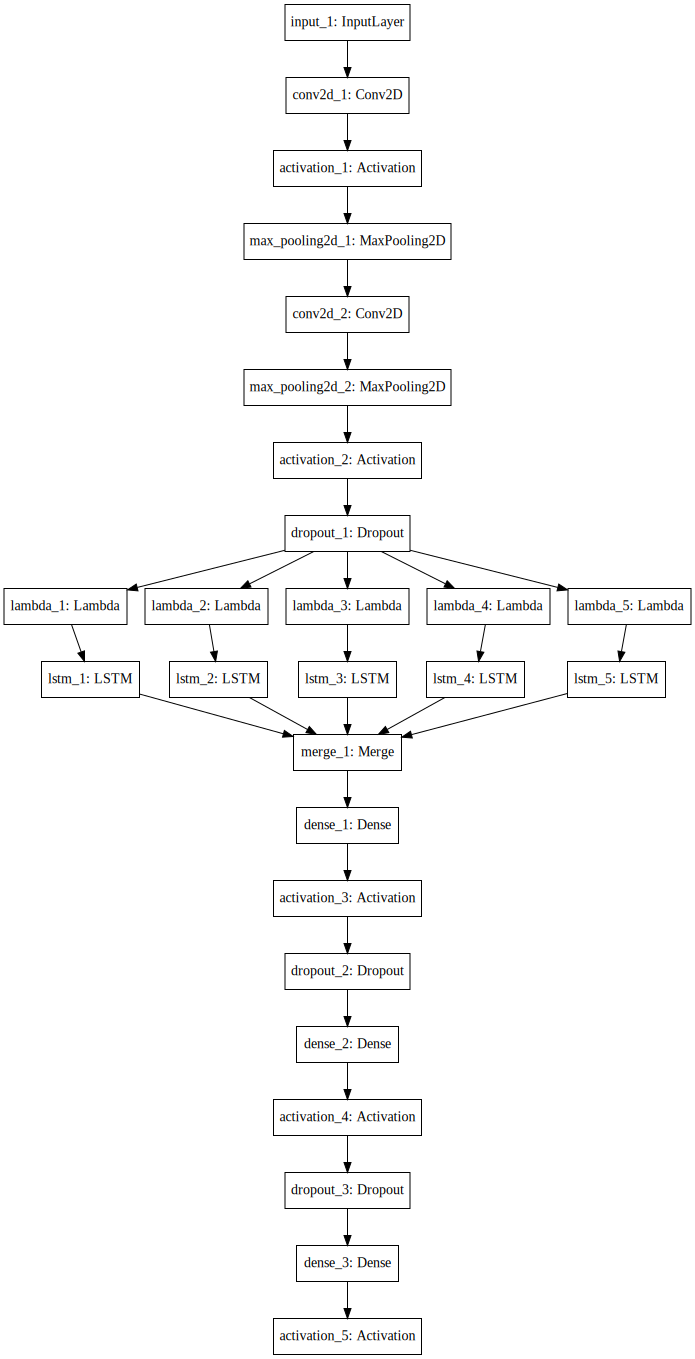

In [1]:
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from keras.layers.core import Activation, Lambda, Dropout 
from keras.layers.recurrent import LSTM
from keras.legacy.layers import merge
from keras.models import Model
from keras.utils.vis_utils import plot_model

K.set_image_dim_ordering("th")

class RJPGNet:
    @staticmethod
    def build(timeSteps,variables,classes,nlstms):
        #CONV=>POOL
        inputNet = Input(shape=(1,timeSteps,variables)) 
        conv1=Conv2D(20, (2,5), padding="same")(inputNet)
        conv1=Activation("relu")(conv1)
        conv1=MaxPooling2D(pool_size=(2, 1), strides=(1, 1))(conv1)
        conv2=Conv2D(nlstms,(3,3), padding="same")(conv1)
        conv2=MaxPooling2D(pool_size=(2, 1), strides=(1, 1))(conv2)
        conv2=Activation("relu")(conv2)
        out1=Dropout(0.40)(conv2)
        lstmsVec=[]
        for x in range(0,nlstms):
            filterImg=Lambda(lambda element : element[:,x,:,:])(out1)
            lstm=LSTM(40,input_shape=(5,5))(filterImg)
            lstmsVec.append(lstm)
        #base example for 2 lstms     
        #x0 = Lambda(lambda x : x[:,0,:,:])(out1)
        #x1 = Lambda(lambda x : x[:,1,:,:])(out1)
        #lstm1=LSTM(40,input_shape=(5,5))(x0)
        #lstm2=LSTM(40,input_shape=(5,5))(x1)
        
        merged = merge(lstmsVec, mode='concat',concat_axis=1)
        
        denselayers=Dense(400)(merged)
        denselayers=Activation("relu")(denselayers)
        denselayers=Dropout(0.5)(denselayers)
        denselayers=Dense(150)(denselayers)
        denselayers=Activation("relu")(denselayers)
        denselayers=Dropout(0.8)(denselayers)
        # a softmax classifier
        classificationLayer=Dense(classes)(denselayers)
        classificationLayer=Activation("softmax")(classificationLayer)
        
        model=Model(inputNet,classificationLayer)
        return model
        
        
#input
#timeSteps=7
#variables=5
#output
#classes=5
#concurret lstms
#nlstms=5

modeltest=RJPGNet.build(timeSteps=7,variables=5,classes=5,nlstms=5)
modeltest.compile(optimizer="adadelta", loss="categorical_crossentropy",metrics=["accuracy"])
modeltest.summary() 

#plot_model(modeltest, to_file="model.png",show_shapes=True)

from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
modelSVG=SVG(model_to_dot(modeltest).create(prog='dot', format='svg'))
display(modelSVG)
